In [1]:
import numpy as np
import pandas as pd

print(np.__version__)
print(pd.__version__)

2.0.2
2.3.3


In [2]:
import os
import glob
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [3]:
DATASET_ROOT = r"C:/Users/sreej/OneDrive/Desktop/ShanghaiTech/part_B"

print(os.listdir(DATASET_ROOT))
print(os.listdir(os.path.join(DATASET_ROOT, "train_data")))
print(os.listdir(os.path.join(DATASET_ROOT, "train_data/images")))
print(os.listdir(os.path.join(DATASET_ROOT, "train_data/ground-truth")))

['test_data', 'train_data']
['ground-truth', 'images']
['IMG_1.jpg', 'IMG_10.jpg', 'IMG_100.jpg', 'IMG_101.jpg', 'IMG_102.jpg', 'IMG_103.jpg', 'IMG_104.jpg', 'IMG_105.jpg', 'IMG_106.jpg', 'IMG_107.jpg', 'IMG_108.jpg', 'IMG_109.jpg', 'IMG_11.jpg', 'IMG_110.jpg', 'IMG_111.jpg', 'IMG_112.jpg', 'IMG_113.jpg', 'IMG_114.jpg', 'IMG_115.jpg', 'IMG_116.jpg', 'IMG_117.jpg', 'IMG_118.jpg', 'IMG_119.jpg', 'IMG_12.jpg', 'IMG_120.jpg', 'IMG_121.jpg', 'IMG_122.jpg', 'IMG_123.jpg', 'IMG_124.jpg', 'IMG_125.jpg', 'IMG_126.jpg', 'IMG_127.jpg', 'IMG_128.jpg', 'IMG_129.jpg', 'IMG_13.jpg', 'IMG_130.jpg', 'IMG_131.jpg', 'IMG_132.jpg', 'IMG_133.jpg', 'IMG_134.jpg', 'IMG_135.jpg', 'IMG_136.jpg', 'IMG_137.jpg', 'IMG_138.jpg', 'IMG_139.jpg', 'IMG_14.jpg', 'IMG_140.jpg', 'IMG_141.jpg', 'IMG_142.jpg', 'IMG_143.jpg', 'IMG_144.jpg', 'IMG_145.jpg', 'IMG_146.jpg', 'IMG_147.jpg', 'IMG_148.jpg', 'IMG_149.jpg', 'IMG_15.jpg', 'IMG_150.jpg', 'IMG_151.jpg', 'IMG_152.jpg', 'IMG_153.jpg', 'IMG_154.jpg', 'IMG_155.jpg', 'IMG_15

In [4]:
train_image_paths = sorted(
    glob.glob(os.path.join(DATASET_ROOT, "train_data/images/*.jpg"))
)
train_gt_paths = sorted(
    glob.glob(os.path.join(DATASET_ROOT, "train_data/ground-truth/*.npy"))
)

test_image_paths = sorted(
    glob.glob(os.path.join(DATASET_ROOT, "test_data/images/*.jpg"))
)
test_gt_paths = sorted(
    glob.glob(os.path.join(DATASET_ROOT, "test_data/ground-truth/*.npy"))
)

print("Train samples:", len(train_image_paths))
print("Test samples:", len(test_image_paths))

Train samples: 400
Test samples: 316


In [5]:
class CrowdDataset(Dataset):
    def __init__(self, image_paths, density_paths):
        self.image_paths = image_paths
        self.density_paths = density_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))  # CHW

        den = np.load(self.density_paths[idx]).astype(np.float32)

        return torch.tensor(img), torch.tensor(den).unsqueeze(0)

In [6]:
train_ds = CrowdDataset(train_image_paths, train_gt_paths)
test_ds = CrowdDataset(test_image_paths, test_gt_paths)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1)

In [7]:
class MCNN(nn.Module):
    def __init__(self):
        super(MCNN, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(3, 16, 9, padding=4),
            nn.ReLU(),
            nn.Conv2d(16, 32, 7, padding=3),
            nn.ReLU(),
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(3, 20, 7, padding=3),
            nn.ReLU(),
            nn.Conv2d(20, 40, 5, padding=2),
            nn.ReLU(),
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(3, 24, 5, padding=2),
            nn.ReLU(),
            nn.Conv2d(24, 48, 3, padding=1),
            nn.ReLU(),
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(32 + 40 + 48, 1, 1),
            nn.ReLU()
        )

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b3 = self.branch3(x)
        out = torch.cat((b1, b2, b3), dim=1)
        return self.fuse(out)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MCNN().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [12]:
import os
import glob
import scipy.io as sio
import numpy as np

gt_folder = r"C:/Users/sreej/OneDrive/Desktop/ShanghaiTech/part_B/train_data/ground-truth"

mat_files = glob.glob(gt_folder + "/*.mat")

print("Found MAT files:", len(mat_files))

for mat_path in mat_files:
    mat = sio.loadmat(mat_path)

    # the key containing density map varies; select automatically
    keys = [k for k in mat.keys() if not k.startswith("__")]
    density = mat[keys[0]]

    # create .npy filename
    np_path = mat_path.replace(".mat", ".npy")

    # save npy
    np.save(np_path, density)

print("Conversion completed!")

Found MAT files: 400
Conversion completed!


In [13]:
train_gt_paths = sorted(
    glob.glob(r"C:/Users/sreej/OneDrive/Desktop/ShanghaiTech/part_B/train_data/ground-truth/*.npy")
)

print("Now density maps =", len(train_gt_paths))


Now density maps = 400


In [16]:
print(len(train_image_paths), len(train_gt_paths))

400 400


In [6]:
# 01 - DATA LOADING
# DeepVision Crowd Monitor
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Set dataset paths
train_img_dir = r"C:/Users/sreej/OneDrive/Desktop/ShanghaiTech/part_B/train_data/images"
train_gt_dir  = r"C:/Users/sreej/OneDrive/Desktop/ShanghaiTech/part_B/train_data/ground-truth"

# Load image paths
train_image_paths = sorted(glob.glob(os.path.join(train_img_dir, "*.jpg")))
train_gt_paths    = sorted(glob.glob(os.path.join(train_gt_dir, "*.npy")))

print("Total training images:", len(train_image_paths))
print("Total training density maps:", len(train_gt_paths))

# Display first 3 image and GT pair
for i in range(3):
    print("Image:", train_image_paths[i])
    print("GT:", train_gt_paths[i])


Total training images: 400
Total training density maps: 400
Image: C:/Users/sreej/OneDrive/Desktop/ShanghaiTech/part_B/train_data/images\IMG_1.jpg
GT: C:/Users/sreej/OneDrive/Desktop/ShanghaiTech/part_B/train_data/ground-truth\GT_IMG_1.npy
Image: C:/Users/sreej/OneDrive/Desktop/ShanghaiTech/part_B/train_data/images\IMG_10.jpg
GT: C:/Users/sreej/OneDrive/Desktop/ShanghaiTech/part_B/train_data/ground-truth\GT_IMG_10.npy
Image: C:/Users/sreej/OneDrive/Desktop/ShanghaiTech/part_B/train_data/images\IMG_100.jpg
GT: C:/Users/sreej/OneDrive/Desktop/ShanghaiTech/part_B/train_data/ground-truth\GT_IMG_100.npy


In [12]:
import numpy as np

data = np.load(sample_gt, allow_pickle=True)
print("Type:", type(data))
print("Shape:", np.shape(data))
print("Content preview:", data)


Type: <class 'numpy.ndarray'>
Shape: (1, 1)
Content preview: [[array([[(array([[  32.67954877,  753.52165403],
                 [ 184.60695349,  690.79933098],
                 [ 344.89733461,  577.8991495 ],
                 [ 328.1713818 ,  536.08426746],
                 [ 329.5652112 ,  473.36194441],
                 [ 643.17682645,  533.29660866],
                 [ 661.29660866,  681.04252518],
                 [ 803.46720757,  580.6868083 ],
                 [ 814.61784278,  502.63236184],
                 [ 757.47083734,  392.51983915],
                 [ 770.01530195,  364.64325113],
                 [ 799.28571937,  315.85922209],
                 [ 728.20041991,  328.4036867 ],
                 [ 899.64143625,  405.06430376],
                 [ 919.15504786,  529.11512046],
                 [ 924.73036547,  278.22582826],
                 [ 965.1514181 ,  250.34924024],
                 [1018.11693534,  236.41094623],
                 [ 938.66865948,  186.23308779],
       

In [14]:
import numpy as np

data = np.load(sample_gt, allow_pickle=True)
print("TYPE:", type(data))
print("LENGTH:", len(data))

print("\nFIRST ELEMENT TYPE:", type(data[0]))
print("FIRST ELEMENT SHAPE:", np.shape(data[0]))

print("\nPreview:")
print(data[0][:10])

TYPE: <class 'numpy.ndarray'>
LENGTH: 1

FIRST ELEMENT TYPE: <class 'numpy.ndarray'>
FIRST ELEMENT SHAPE: (1,)

Preview:
[array([[(array([[  32.67954877,  753.52165403],
                [ 184.60695349,  690.79933098],
                [ 344.89733461,  577.8991495 ],
                [ 328.1713818 ,  536.08426746],
                [ 329.5652112 ,  473.36194441],
                [ 643.17682645,  533.29660866],
                [ 661.29660866,  681.04252518],
                [ 803.46720757,  580.6868083 ],
                [ 814.61784278,  502.63236184],
                [ 757.47083734,  392.51983915],
                [ 770.01530195,  364.64325113],
                [ 799.28571937,  315.85922209],
                [ 728.20041991,  328.4036867 ],
                [ 899.64143625,  405.06430376],
                [ 919.15504786,  529.11512046],
                [ 924.73036547,  278.22582826],
                [ 965.1514181 ,  250.34924024],
                [1018.11693534,  236.41094623],
              

In [16]:
raw = np.load(sample_gt, allow_pickle=True)
print("TYPE:", type(raw))
print("SHAPE:", getattr(raw, "shape", None))
print("DTYPE:", getattr(raw, "dtype", None))

TYPE: <class 'numpy.ndarray'>
SHAPE: (1, 1)
DTYPE: object


In [17]:
print(raw)

[[array([[(array([[  32.67954877,  753.52165403],
                 [ 184.60695349,  690.79933098],
                 [ 344.89733461,  577.8991495 ],
                 [ 328.1713818 ,  536.08426746],
                 [ 329.5652112 ,  473.36194441],
                 [ 643.17682645,  533.29660866],
                 [ 661.29660866,  681.04252518],
                 [ 803.46720757,  580.6868083 ],
                 [ 814.61784278,  502.63236184],
                 [ 757.47083734,  392.51983915],
                 [ 770.01530195,  364.64325113],
                 [ 799.28571937,  315.85922209],
                 [ 728.20041991,  328.4036867 ],
                 [ 899.64143625,  405.06430376],
                 [ 919.15504786,  529.11512046],
                 [ 924.73036547,  278.22582826],
                 [ 965.1514181 ,  250.34924024],
                 [1018.11693534,  236.41094623],
                 [ 938.66865948,  186.23308779],
                 [ 896.85377745,  168.11330558],
                 [ 

In [22]:
import os

for root, dirs, files in os.walk(".", topdown=True):
    for f in files:
        if f.endswith(".mat"):
            print(os.path.join(root, f))

.\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests\data\bad_miuint32.mat
.\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests\data\bad_miutf8_array_name.mat
.\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests\data\big_endian.mat
.\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests\data\broken_utf8.mat
.\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests\data\corrupted_zlib_checksum.mat
.\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests\data\corrupted_zlib_data.mat
.\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests\data\little_endian.mat
.\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests\data\logical_sparse.mat
.\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests\data\malformed1.mat
.\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests\data\miuint32_for_miint32.mat
.\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests

In [26]:
import os

print(os.listdir(r"C:\Users"))

['All Users', 'Default', 'Default User', 'desktop.ini', 'Public', 'sreej']


In [27]:
import os

root = fr"C:\Users\<USERNAME>"

for folder, subfolders, files in os.walk(root):
    for f in files:
        if f.endswith(".mat"):
            print(os.path.join(folder, f))

In [28]:
import os

root = r"C:\Users\sreej"

print("Searching .mat files...\n")

found = []
for folder, subfolders, files in os.walk(root):
    for f in files:
        if f.endswith(".mat"):
            found.append(os.path.join(folder, f))

if found:
    print("Found .mat files:\n")
    for p in found:
        print(p)
else:
    print("No .mat files found under your User directory.")


Searching .mat files...

Found .mat files:

C:\Users\sreej\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests\data\bad_miuint32.mat
C:\Users\sreej\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests\data\bad_miutf8_array_name.mat
C:\Users\sreej\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests\data\big_endian.mat
C:\Users\sreej\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests\data\broken_utf8.mat
C:\Users\sreej\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests\data\corrupted_zlib_checksum.mat
C:\Users\sreej\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests\data\corrupted_zlib_data.mat
C:\Users\sreej\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests\data\little_endian.mat
C:\Users\sreej\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests\data\logical_sparse.mat
C:\Users\sreej\anaconda3\envs\deepvision\Lib\site-packages\scipy\io\matlab\tests\data\malformed1.mat
C:\U

In [29]:
import os

# Set your dataset paths
gt_dir = r"C:\Users\sreej\OneDrive\Desktop\ShanghaiTech\part_B\train_data\ground-truth"
img_dir = r"C:\Users\sreej\OneDrive\Desktop\ShanghaiTech\part_B\train_data\images"

print("Ground-truth folder exists:", os.path.isdir(gt_dir))
print("Images folder exists:", os.path.isdir(img_dir))

# List sample files
print("\nSample .mat files:", os.listdir(gt_dir)[:5])
print("Sample images:", os.listdir(img_dir)[:5])

Ground-truth folder exists: True
Images folder exists: True

Sample .mat files: ['GT_IMG_1.mat', 'GT_IMG_1.npy', 'GT_IMG_10.mat', 'GT_IMG_10.npy', 'GT_IMG_100.mat']
Sample images: ['IMG_1.jpg', 'IMG_10.jpg', 'IMG_100.jpg', 'IMG_101.jpg', 'IMG_102.jpg']


In [33]:
import scipy.io as sio
import os

gt_dir = r"C:\Users\sreej\OneDrive\Desktop\ShanghaiTech\part_B\train_data\ground-truth"

mat = sio.loadmat(os.path.join(gt_dir, "GT_IMG_1.mat"))

# Extract (points, count)
data = mat["image_info"][0][0][0][0]

points = data[0]          # ← (N,2) array of head locations
count = int(data[1][0][0])  # ← not required, but useful to verify

print("points shape:", points.shape)
print("first 5 points:\n", points[:5])
print("count from mat:", count, "| computed:", len(points))


points shape: (233, 2)
first 5 points:
 [[ 32.67954877 753.52165403]
 [184.60695349 690.79933098]
 [344.89733461 577.8991495 ]
 [328.1713818  536.08426746]
 [329.5652112  473.36194441]]
count from mat: 233 | computed: 233


In [34]:
#Data loading and Preprocessing)
import os
import glob
import cv2
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# Dataset paths
train_img_dir = r"C:/Users/sreej/OneDrive/Desktop/ShanghaiTech/part_B/train_data/images"
train_gt_dir  = r"C:/Users/sreej/OneDrive/Desktop/ShanghaiTech/part_B/train_data/ground-truth"

train_image_paths = sorted(glob.glob(os.path.join(train_img_dir, "*.jpg")))
train_gt_paths    = sorted(glob.glob(os.path.join(train_gt_dir, "*.mat")))

print("Total training images:", len(train_image_paths))
print("Total MAT files:", len(train_gt_paths))


Total training images: 400
Total MAT files: 400


In [35]:
# Load and inspect one GT file

sample_gt = train_gt_paths[0]
sample_img = train_image_paths[0]

print("Image:", sample_img)
print("GT:", sample_gt)

mat = sio.loadmat(sample_gt)

# Extract tuple: (points, count)
data = mat["image_info"][0][0][0][0]

points = data[0]     # shape (N,2)
count  = int(data[1][0][0])

print("points shape:", points.shape)
print("first 5 points:\n", points[:5])
print("count:", count)


Image: C:/Users/sreej/OneDrive/Desktop/ShanghaiTech/part_B/train_data/images\IMG_1.jpg
GT: C:/Users/sreej/OneDrive/Desktop/ShanghaiTech/part_B/train_data/ground-truth\GT_IMG_1.mat
points shape: (233, 2)
first 5 points:
 [[ 32.67954877 753.52165403]
 [184.60695349 690.79933098]
 [344.89733461 577.8991495 ]
 [328.1713818  536.08426746]
 [329.5652112  473.36194441]]
count: 233


In [38]:
#Density_Map_Generation
#Generate Gaussian Map
import numpy as np
import scipy.spatial
import scipy.ndimage

def generate_density_map(img, points):
    """
    img: numpy array (H,W,3)
    points: (N,2) array of [x,y]
    """
    h, w = img.shape[:2]

    density = np.zeros((h, w), dtype=np.float32)

    if len(points) == 0:
        return density

    # KD-tree for adaptive sigma
    tree = scipy.spatial.KDTree(points)

    # For each point generate a Gaussian
    for i, (x, y) in enumerate(points):

        x = min(w - 1, max(0, int(x)))
        y = min(h - 1, max(0, int(y)))

        density[y, x] = 1

        # get nearest 3 neighbors for adaptive sigma
        distances, _ = tree.query([x, y], k=4)
        sigma = (distances[1] + distances[2] + distances[3]) * 0.1

        if sigma == 0:
            sigma = 1.5

        density = scipy.ndimage.gaussian_filter(density, sigma, mode='constant')

    return density

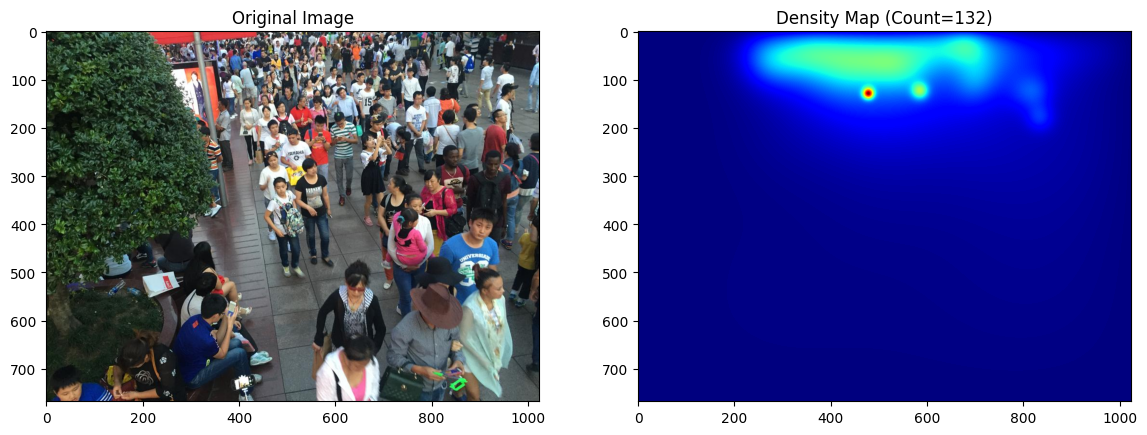

In [39]:
#Visualize Density Map
# Load one sample image + points
img = cv2.imread(sample_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

density = generate_density_map(img, points)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(density, cmap='jet')
plt.title(f"Density Map (Count={int(density.sum())})")

plt.show()


Processing: IMG_1.jpg


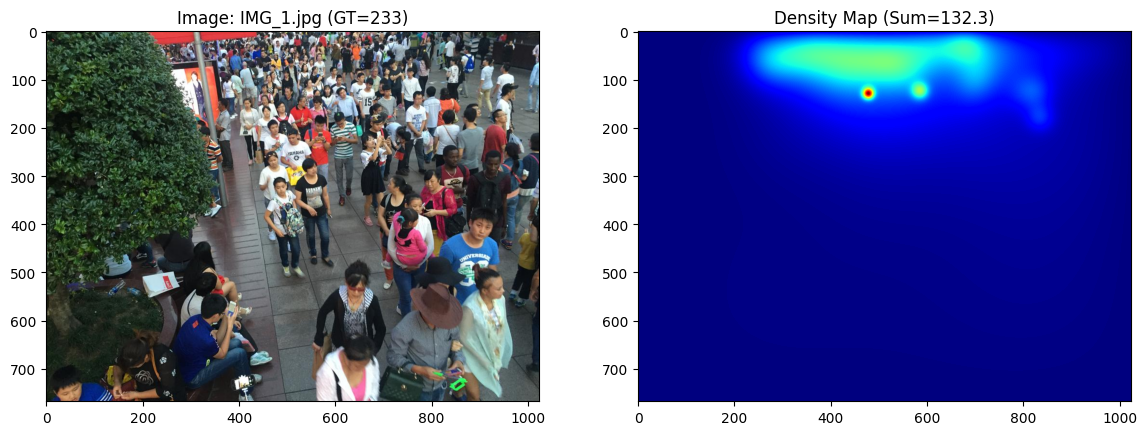


Processing: IMG_10.jpg


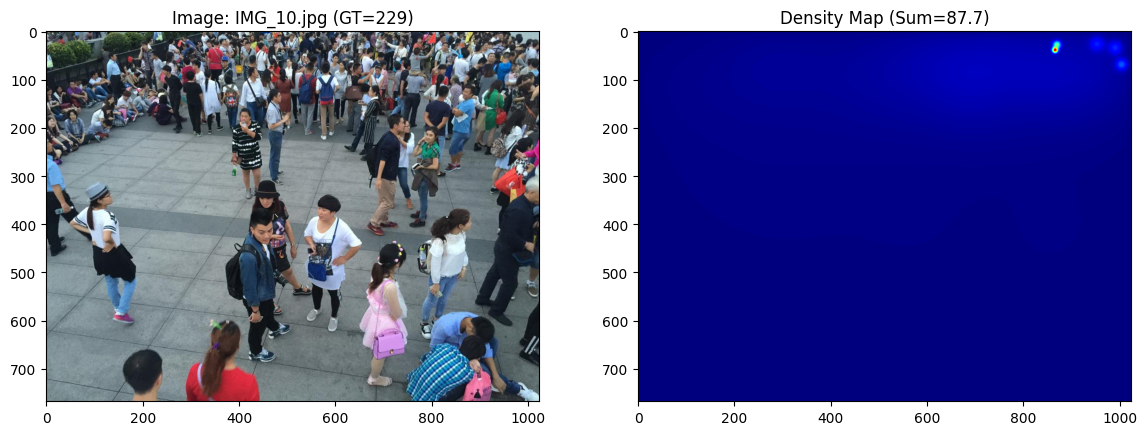


Processing: IMG_100.jpg


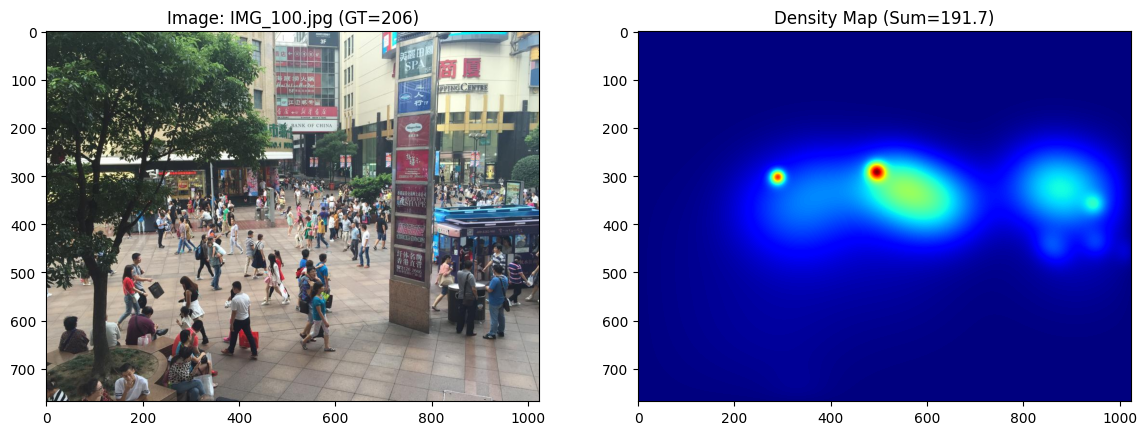


Processing: IMG_101.jpg


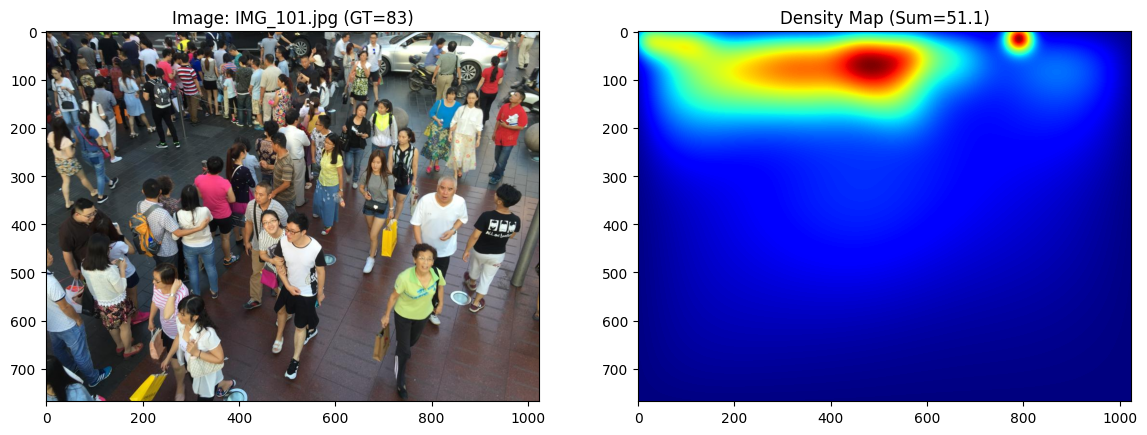


Processing: IMG_102.jpg


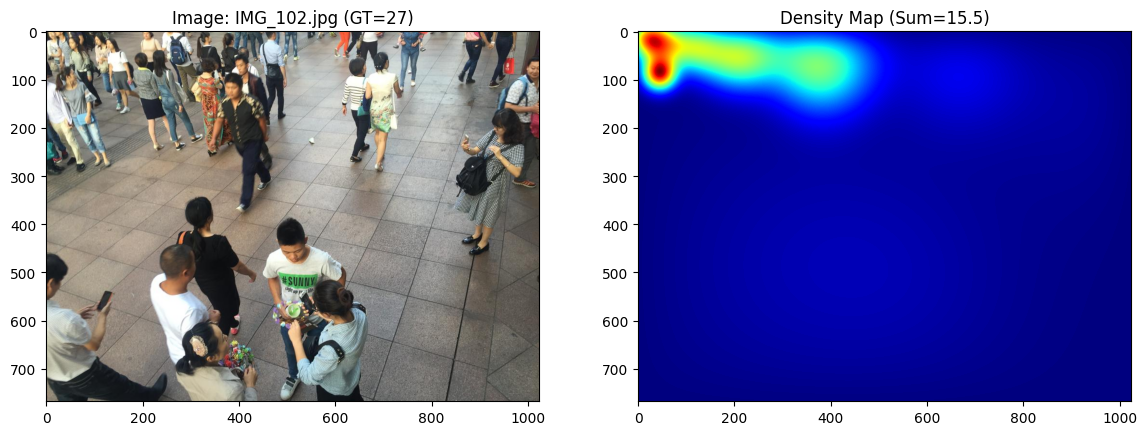

In [40]:
# Generate density maps for few images
num_samples = 5

for i in range(num_samples):
    img_path = train_image_paths[i]
    gt_path  = train_gt_paths[i]

    print(f"\nProcessing: {os.path.basename(img_path)}")

    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load GT
    mat = sio.loadmat(gt_path)
    data = mat['image_info'][0][0][0][0]
    points = data[0]      # (N,2)
    count  = int(data[1][0][0])

    # Generate density map
    density = generate_density_map(img, points)

    # Plot
    plt.figure(figsize=(14,5))
    
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Image: {os.path.basename(img_path)} (GT={count})")
    
    plt.subplot(1,2,2)
    plt.imshow(density, cmap='jet')
    plt.title(f"Density Map (Sum={density.sum():.1f})")

    plt.show()
